In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from scipy import signal
from scipy.optimize import curve_fit
from scipy import stats
from numpy.polynomial.polynomial import polyval

plt.style.use('seaborn')
%matplotlib inline
sns.set()

# Schneider Park, May 10, 2021

Curve fitting to the Schneider park dataset.

The output from these curve fitting functions match David's Igor Pro output on the soil canister dataset, except that his RMSE values are exactly 100x my values.  I therefore am plotting RMSE * 100 in these plots.

In [2]:
def spec_fit(x, c0, c1, c2, c3, w1, w2, f1):
    '''
    A function for fitting peaks to spectra.
    This fit function was copy-pasted in as text from David's fit function on 5/11/21.
    There are two water peaks (free water and bound water) modeled as gaussian peaks w1 and w2.
    There is the f1 fatty acid peak.
    There is a three-term polynomial function.

    :param x: input data
    :param c0: polynomial term 1
    :param c1: polynomial term 2
    :param c2: polynomial term 3
    :param c3: polynomial term 4
    :param w1: water peak term 1
    :param w2: water peak term 2
    :param f1: fatty acid peak
    :return:
    '''

    f_of_x = c0+c1*(x-1700)+c2*(x-1700)**2+c3*(x-1700)**3 + \
             w1*(0.0751747*np.exp(-(x-1903.82)**2/26.4725**2)+0.225213*np.exp(-(x-1942.21)**2/48.8781**2) +
                 0.005*np.exp(-(x-1779.71)**2/32.1869**2))/7.715 + \
             w2*(0.0280945*np.exp(-(x-1913.6)**2/25.0449**2)+0.103527*np.exp(-(x-1949.5)**2/52.2024**2))/3.07 + \
             f1*(0.31*np.exp(-(x-(1730-24))**2/17**2)+np.exp(-(x-1730)**2/17**2)+0.39 *
                 np.exp(-(x-(1730+31))**2/17**2))/25.484
    return f_of_x

def model_fit(df, wave_array):
    '''
    Performs spec_fit function on the input spectra.

    Input parameters:
    df is dataframe containing only the spectra, without extraneous columns
    wave_array is np.array containing the wavelengths of spectra

    Return values:
    modelparams is np.array of parameters output from curve_fit
    modelcovar is np.array of covariance array output from curve_fit
    modeled_spectra is np.array of the modeled spectra using the curve_fit parameters
    residual_spectra is np.array of the original spectrum - the modeled spectrum

    '''
    number = df.shape[0]
    modelparams = np.empty((number, 7), dtype=float)
    modelcovar = np.empty((number, 7, 7), dtype=float)
    modeled_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    residual_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    for i in range(number):
        row = df.iloc[i, :]
        modeled, pcov = curve_fit(spec_fit, wave_array, row)
        modelparams[i, :] = modeled
        modelcovar[i, ::] = pcov
        modeled_spectra[i, :] = spec_fit(wave_array, *modeled)
        residual_spectra[i, :] = row - modeled_spectra[i, :]
    return modelparams, modelcovar, modeled_spectra, residual_spectra


def extract_farray(modelparams):
    '''
    Convenience function to create an np.array containing only the f1 values

    Input:  the modelparams np.array created by model_fit().
    '''
    return modelparams[:, 6]


def create_modelparams_df(modelparams):
    columns = ['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']
    modelparams_df = pd.DataFrame(data=modelparams, columns=columns)
    return modelparams_df


def extract_f_sd_err(modelcovar):
    '''
    Convenience function to create an np.array containing the standard deviation
       of the covariance matrix for the f1 term.

    Input:  the modelcovar np.array created by model_fit().

    '''
    f_sd_err = np.empty(modelcovar.shape[0])
    for i in range(modelcovar.shape[0]):
        f_sd_err[i] = np.diag(modelcovar[i, :, :])[6]
    return f_sd_err


def high_f1_numbers(farray, threshold):
    '''
    Returns np.array of the index positions of spectra with f1 values greater than the
       threshold.  Use this with iloc to find the appropriate rows in the dataframe.

    Input:  np.array output from extract_farray() and desired threshold value.
    '''
    return np.where(farray > threshold)[0]


def get_visible_wavelength_vector(file_path, calibration_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        wavelength_vector = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return wavelength_vector


def get_visible_insertion_absorbance_depth_df(file_path, insertion_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        absorbance_depth = h5_file[f"{insertion_path_str}/derived/absorbance_depth"][:]
        calibration_path_str = insertion_path_str[:17]
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        length = wavelength_vector.shape[0]
        columns = list(np.arange(0, length, 1))
        columns.append('force')
        columns.append('depth')
        dataframe = pd.DataFrame(data=absorbance_depth, columns=columns)
        return dataframe


def create_insertions_date_dataframe(spreadsheet, date_selection):
    df = pd.read_csv(spreadsheet)
    selected_df = df.loc[df['date'] == date_selection]
    return selected_df

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
spreadsheet = 'data/nirone_misc_insertions.csv'
date_selection = '5/10/21'
f1_threshold = 0.06

selected_date_df = create_insertions_date_dataframe(spreadsheet, date_selection)

high_f1_df = pd.DataFrame()
all_values_df = pd.DataFrame()

# not including the last insertion as it was a white test blank insertion
for index in selected_date_df.index.unique()[:-1]:

    # Determine variables for getting the appropriate data
    file_name = selected_date_df['file_name'][index]
    file = path_name + file_name
    calibration_path = selected_date_df['session'][index] + '/' + selected_date_df['calibration'][index]
    insertion_path = calibration_path + '/' + selected_date_df['insertion'][index]

    # Get the wavelength vector
    waves = get_visible_wavelength_vector(file, calibration_path)

    # Get the absorbance-force-depth dataset and put in DataFrame format
    absorbance_depth_df = get_visible_insertion_absorbance_depth_df(file, insertion_path)
    absorbance_depth_df['file_name'] = file_name
    absorbance_depth_df['insertion'] = insertion_path

    # The model input is only the absorbances part of the dataset
    absorbances = absorbance_depth_df.iloc[:, :-4]

    # Run the model
    modelparams, modelcovar, modeled_spectra, residual_spectra = model_fit(absorbances, waves)

    # Calculate the standard deviation of the covariance matrix for the f1 term
    sd_err = extract_f_sd_err(modelcovar)
    absorbance_depth_df['sd_err'] = sd_err

    # RMSE?
    squared_errors = np.square(residual_spectra)
    mse = np.mean(squared_errors, axis=1)
    rmse = np.sqrt(mse)
    absorbance_depth_df['rmse'] = rmse


    # Get the f1 array from the model parameters
    farray = extract_farray(modelparams)
    # absorbance_depth_df['f1_value'] = farray
    absorbance_depth_df[['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']] = modelparams

    # Determine which of the f1 numbers meet the desired threshold
    ins_high_f1s = high_f1_numbers(farray, f1_threshold)

    # Find the spectra that meet the high f1 threshold
    high_spectra = absorbance_depth_df.iloc[ins_high_f1s, :].copy()

    # Append the spectra to the dataframes
    high_f1_df = pd.concat([high_f1_df, high_spectra], ignore_index=True, sort=False)
    all_values_df = pd.concat([all_values_df, absorbance_depth_df], ignore_index=True, sort=False)

# Distribution of F1 values across the dataset

In [4]:
all_values_df['f1'].describe()

count    1188.000000
mean       -0.049682
std         0.035808
min        -0.191197
25%        -0.072433
50%        -0.046781
75%        -0.022319
max         0.083730
Name: f1, dtype: float64

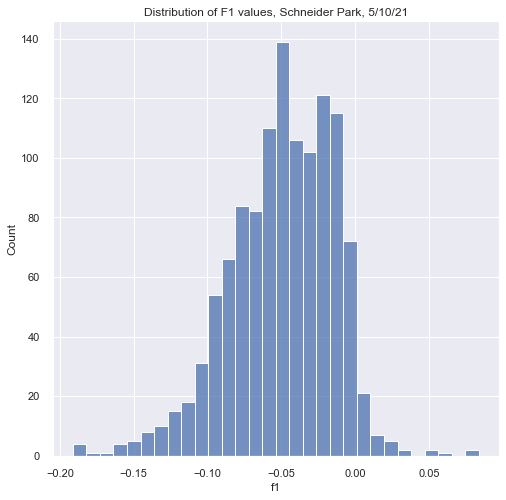

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Distribution of F1 values, Schneider Park, 5/10/21")
sns.histplot(data=all_values_df, x='f1')
plt.show()
plt.close()

# Distribution of F1 values by insertion

Histogram plot of F1 values by insertion.

The sine-shaped variation in the distributions from first to last insertion bothers me.  All f1 values were small. 

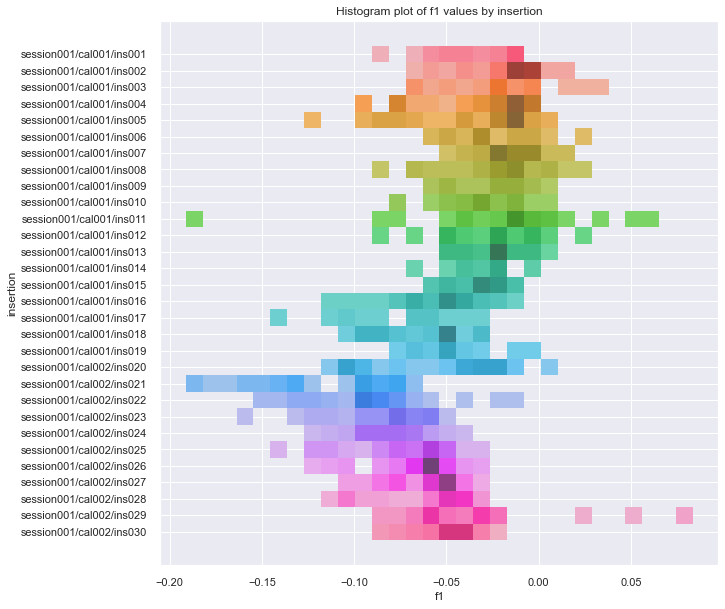

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of f1 values by insertion")
sns.histplot(data=all_values_df, x='f1', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

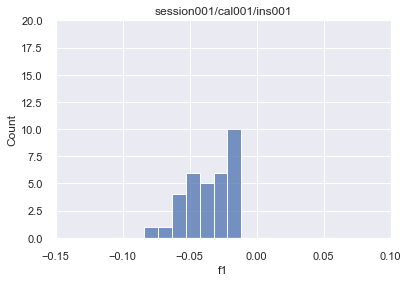

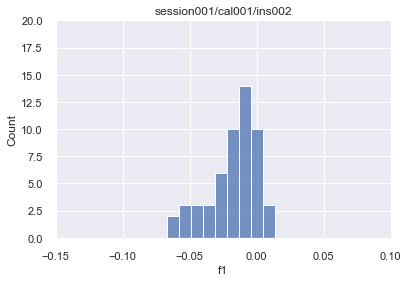

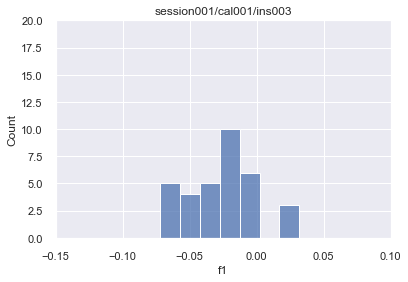

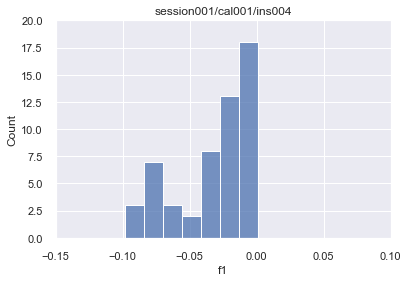

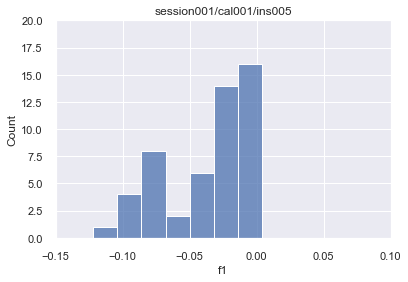

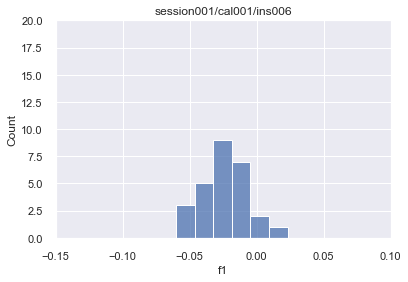

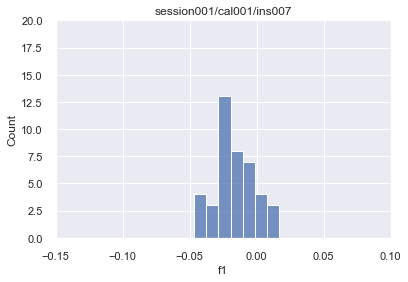

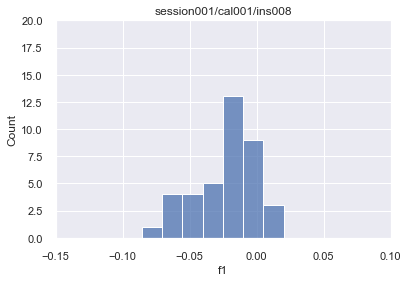

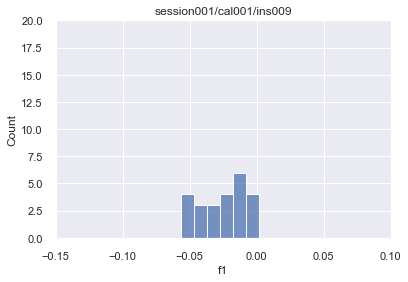

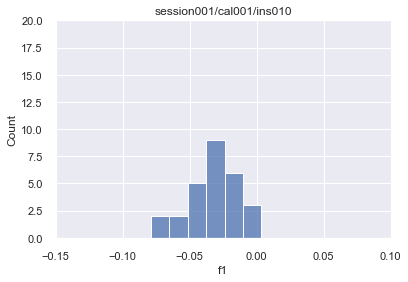

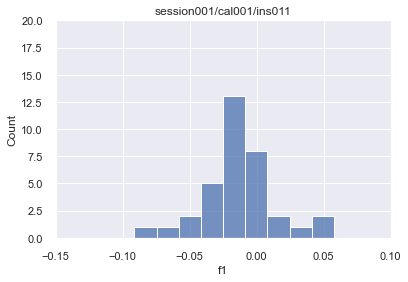

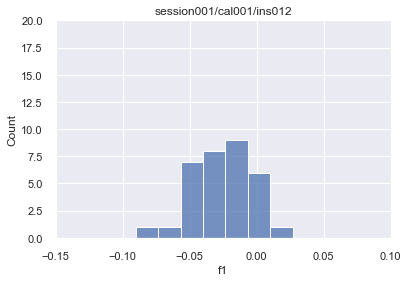

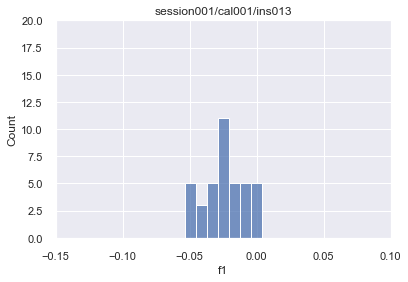

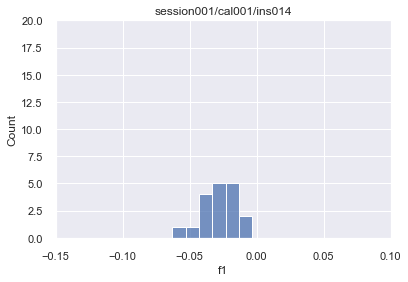

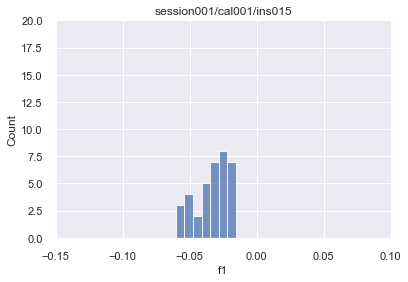

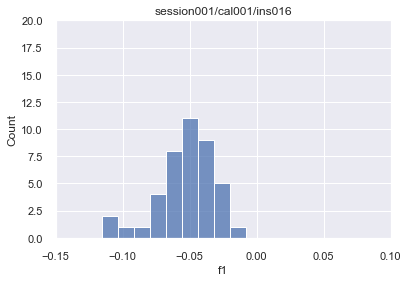

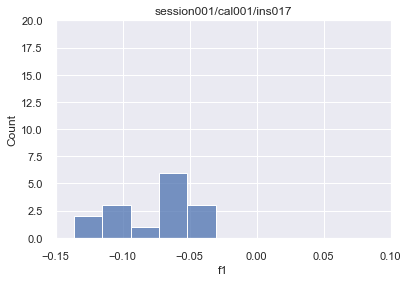

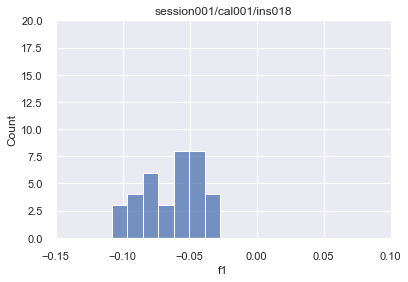

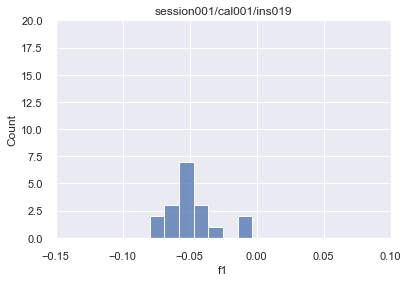

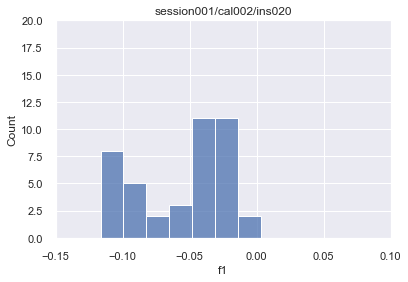

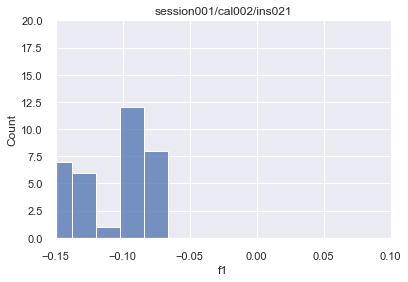

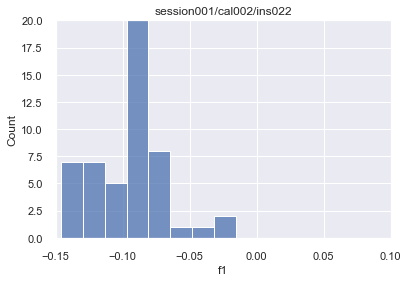

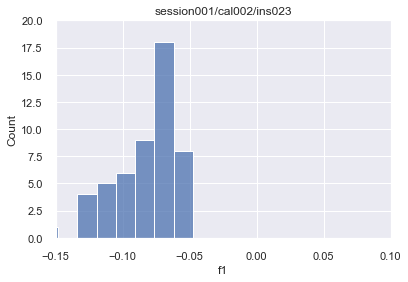

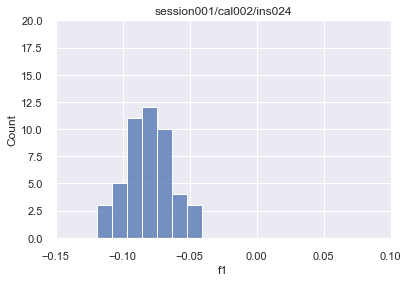

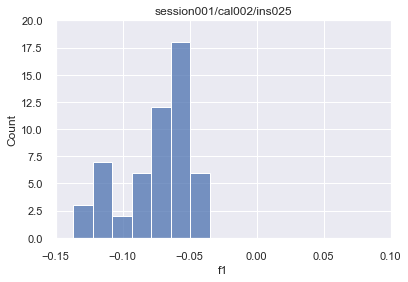

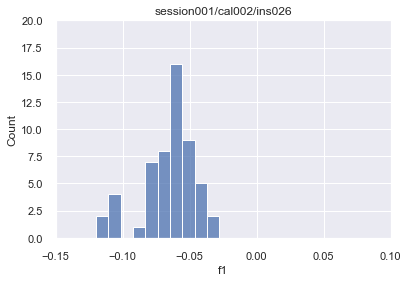

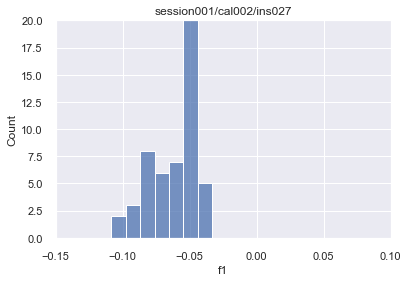

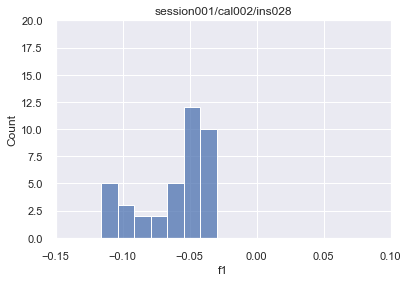

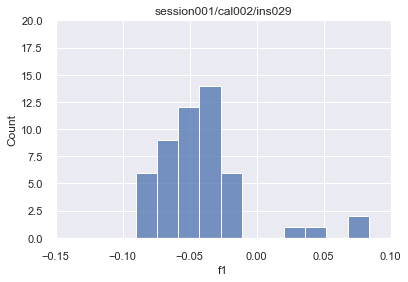

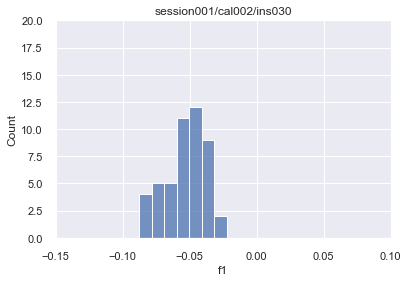

In [7]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots()
    ax.set_title(insertion)
    ax.set_xlim(-0.15, 0.10)
    ax.set_ylim(0, 20)
    sns.histplot(data=plot_df, x='f1')
    plt.show()
    plt.close()

# Distribution of RMSE values across the dataset

In [8]:
(all_values_df['rmse'] * 100).describe()



count    1188.000000
mean        0.082472
std         0.017609
min         0.042701
25%         0.071844
50%         0.081493
75%         0.090841
max         0.259603
Name: rmse, dtype: float64

In [9]:
all_values_df['rmse100'] = all_values_df['rmse']*100

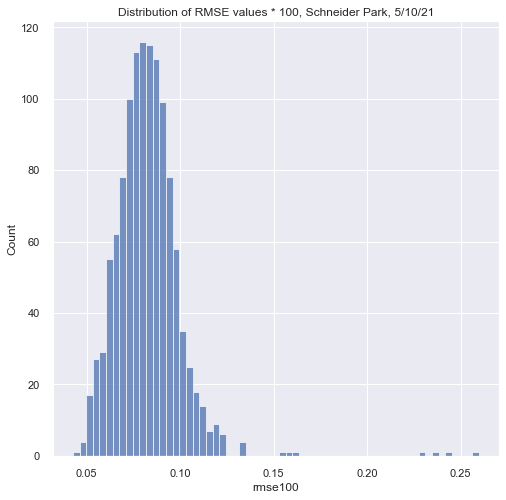

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Distribution of RMSE values * 100, Schneider Park, 5/10/21")
sns.histplot(data=all_values_df, x='rmse100')
plt.show()
plt.close()

# Distribution of RMSE values by insertion

RMSE values are small, and the distribution does not vary from insertion to insertion.

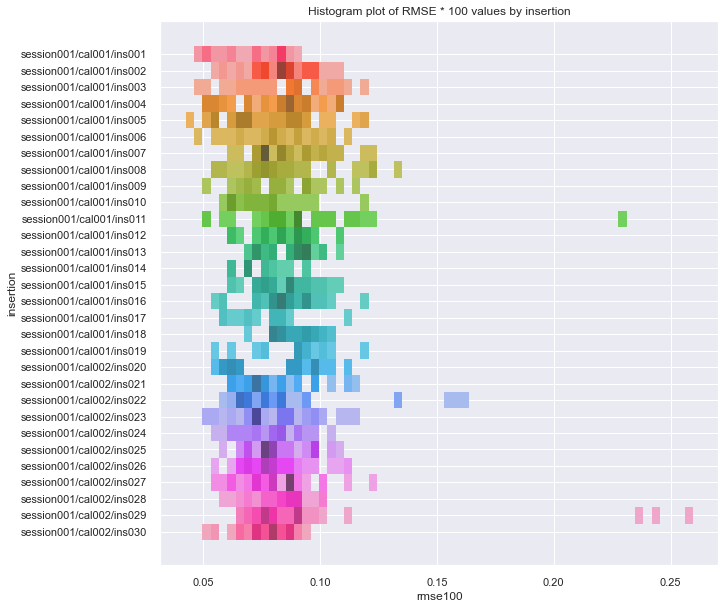

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of RMSE * 100 values by insertion")
sns.histplot(data=all_values_df, x='rmse100', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

# F1 values by depth for each insertion

The few relatively high F1 values are near the surface and don't seem likely to indicate much.

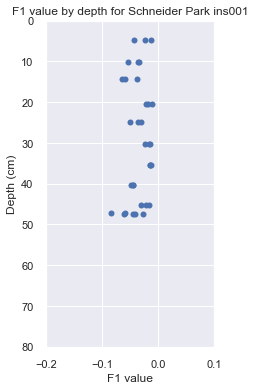

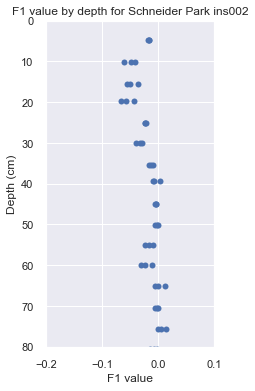

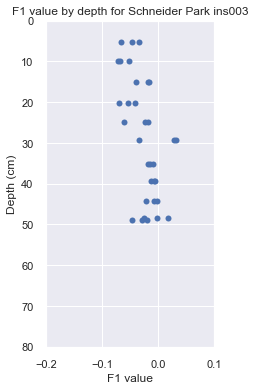

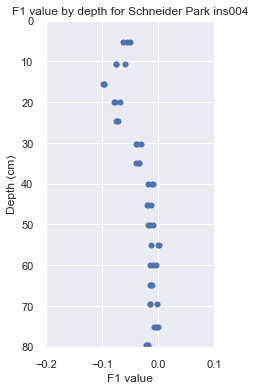

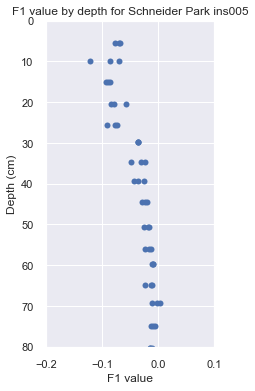

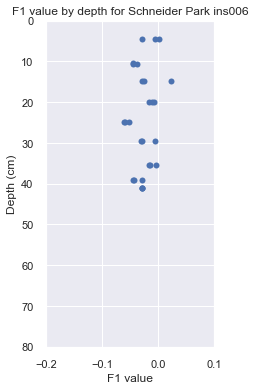

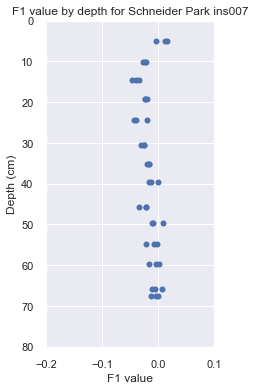

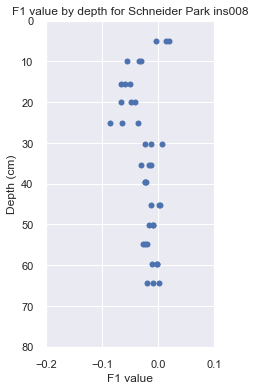

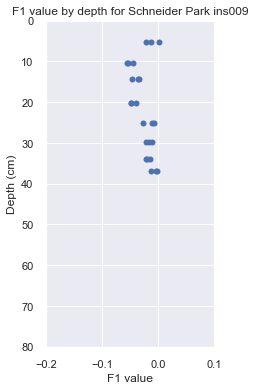

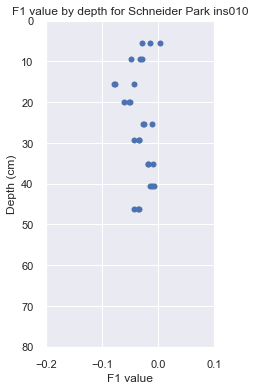

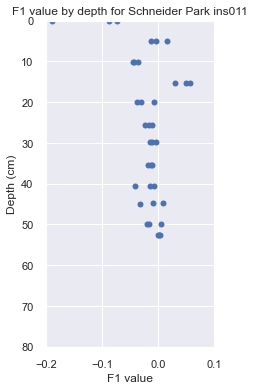

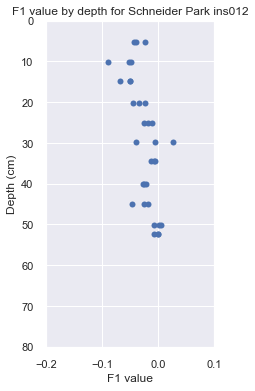

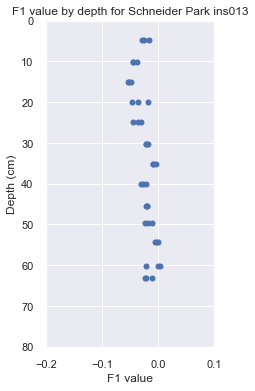

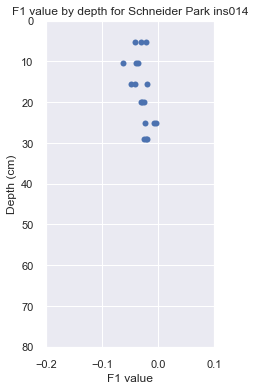

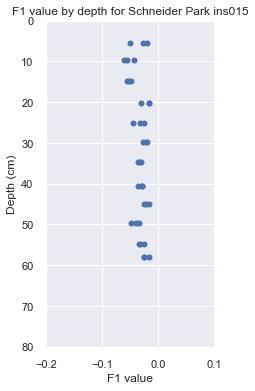

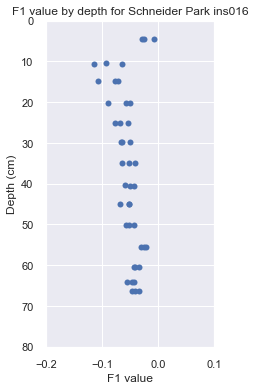

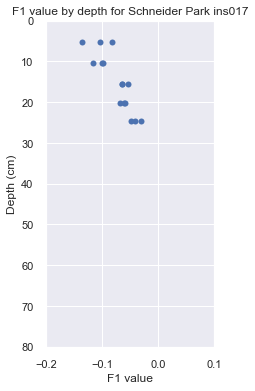

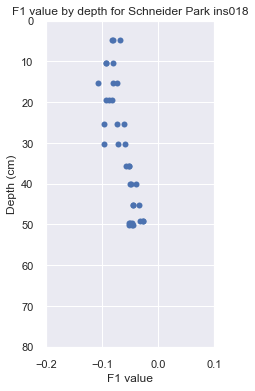

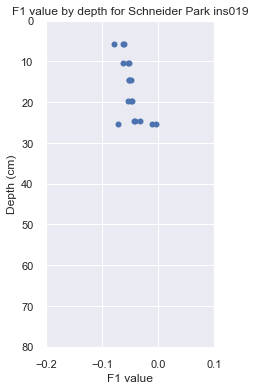

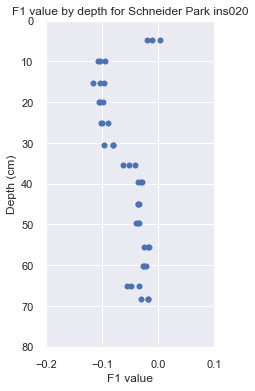

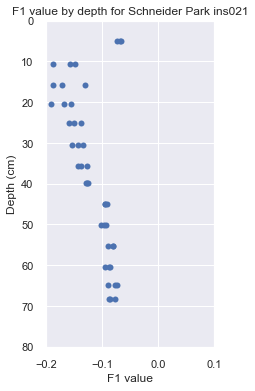

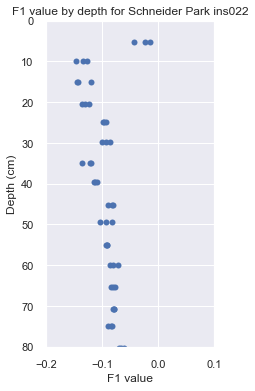

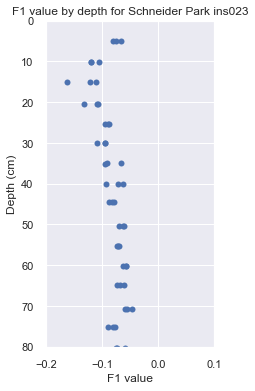

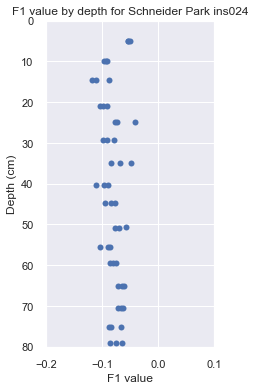

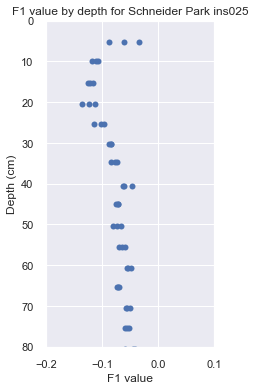

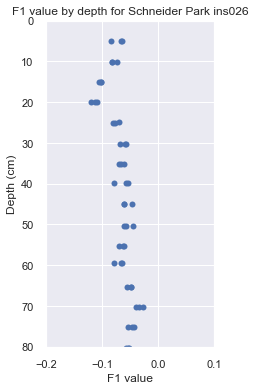

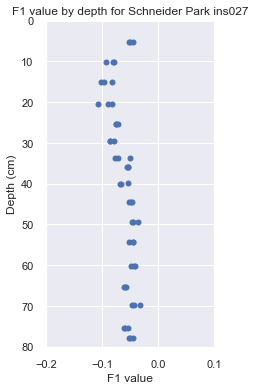

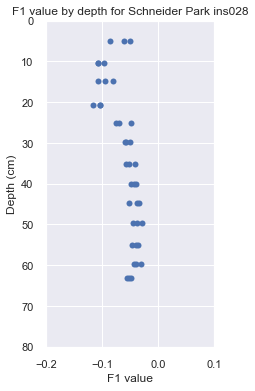

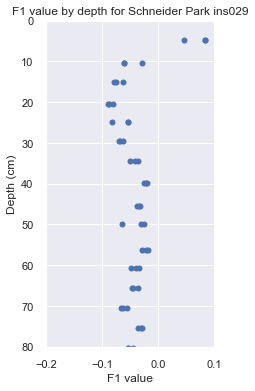

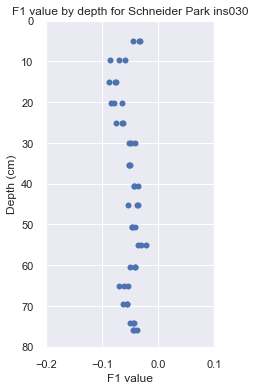

In [12]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.set_title(f"F1 value by depth for Schneider Park {insertion[-6:]}")
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("F1 value")
    ax.set_ylim(80.0, 0.0)
    ax.set_xlim(-0.2, 0.1)
    ax.plot(plot_df['f1'], plot_df['depth'], 'o')
    plt.show()
    plt.close()

# RMSE values by depth

The few spectra with high-ish F1 values also have higher RMSE values.

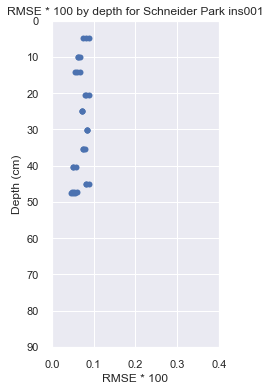

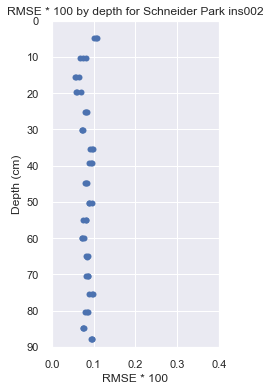

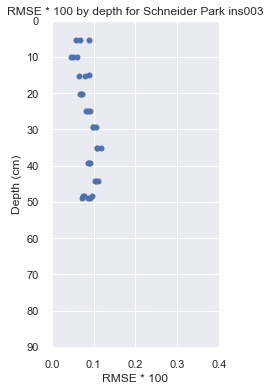

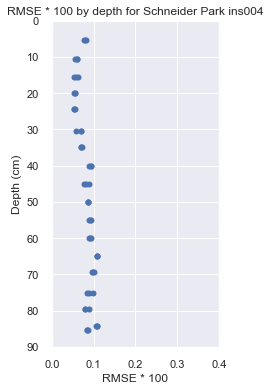

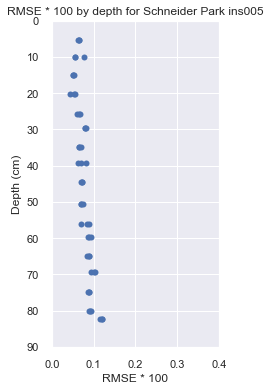

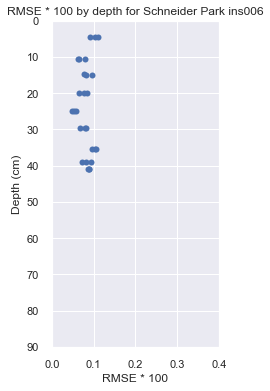

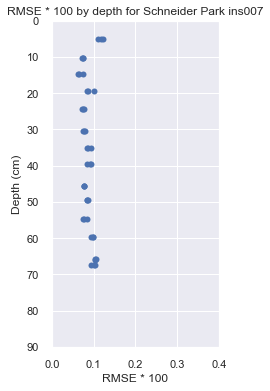

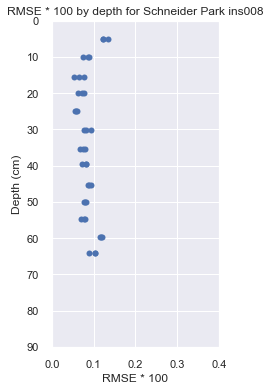

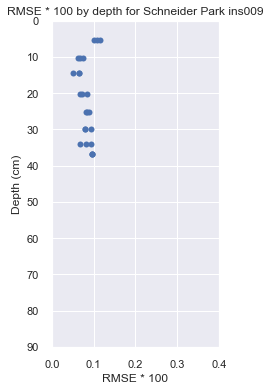

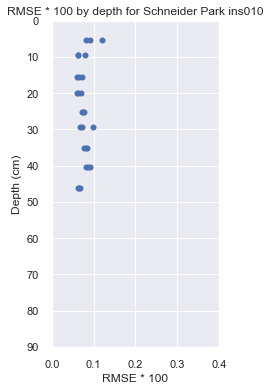

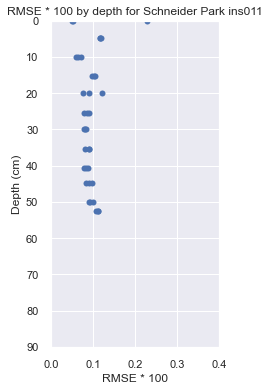

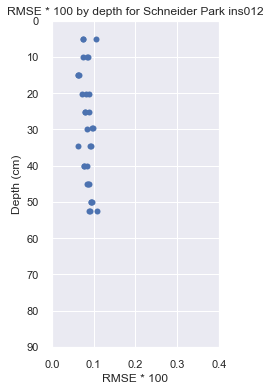

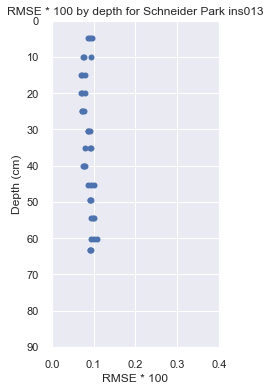

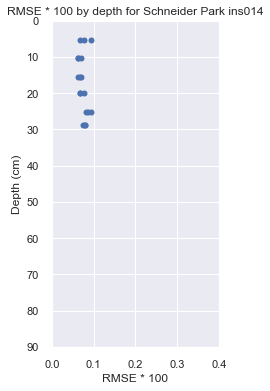

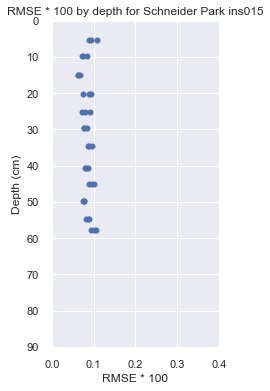

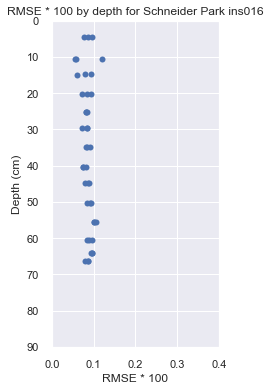

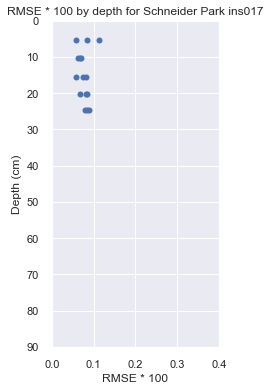

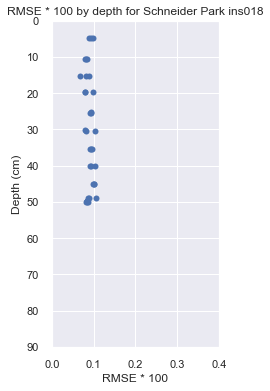

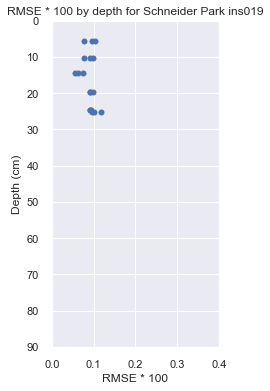

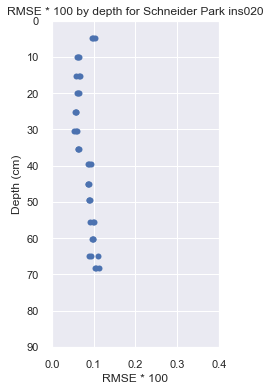

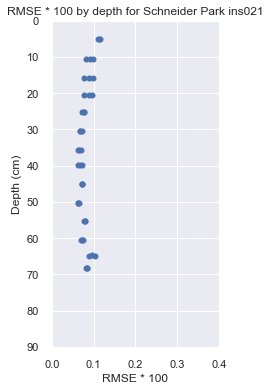

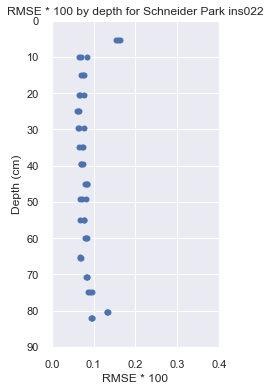

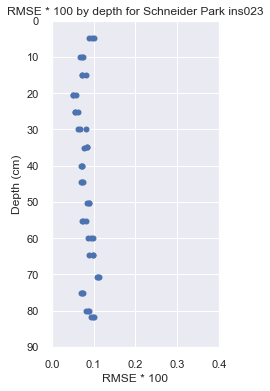

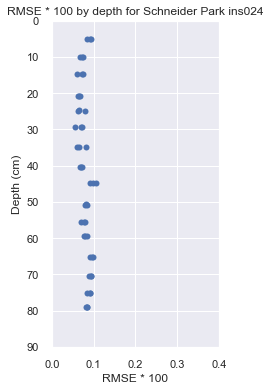

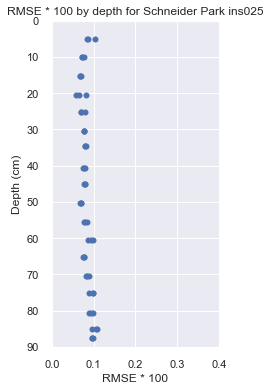

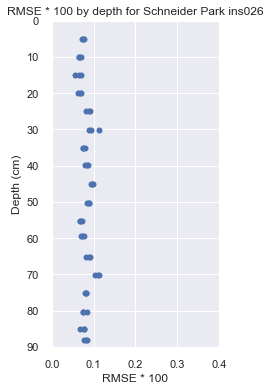

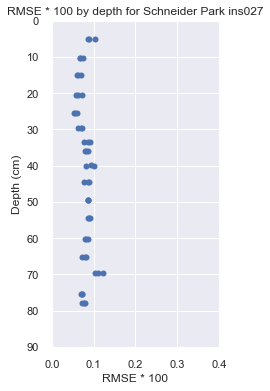

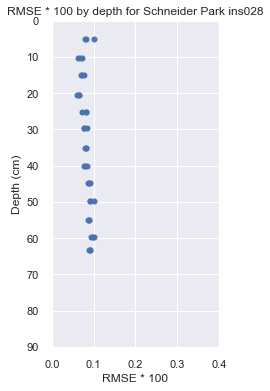

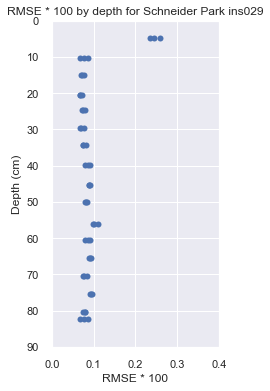

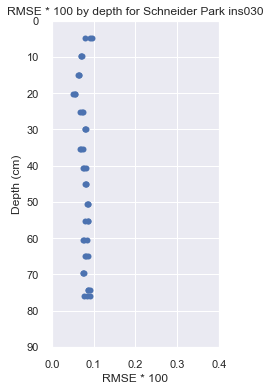

In [13]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.set_title(f"RMSE * 100 by depth for Schneider Park {insertion[-6:]}")
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("RMSE * 100")
    ax.set_ylim(90.0, 0.0)
    ax.set_xlim(0, 0.4)
    ax.plot(plot_df['rmse'] * 100, plot_df['depth'], 'o')
    plt.show()
    plt.close()

In [14]:
soil_canister_results = pd.read_csv('data/soil_canister_output_210512.csv')

In [15]:
all_values_df.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 20

In [16]:
soil_canister_results.columns.values

array(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42',
       '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64',
       '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75',
       '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86',
       '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97',
       '98', '99', '100', '101', '102', '103', '104', '105', '106', '107',
       '108', '109', '110', '111', '112', '113', '114', '115', '116',
       '117', '118', '119', '120', '121', '122', '123', '124', '125',
       '126', '127', '128', '129', '130', '131', '132', '133', '134',
       '135', '136', '137', '138', '139', '140', '141', '142

In [17]:
columns = ['force', 'depth', 'file_name', 'insertion', 'sd_err', 'rmse', 'c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']

In [18]:
schneider_results = all_values_df[columns].copy()

In [19]:
schneider_results

,force,depth,file_name,insertion,sd_err,rmse,c0,c1,c2,c3,w1,w2,f1
0,157534.5,4.748428,210510_schneider_park/schneider_park_210510.h5,session001/cal001/ins001,0.000026,0.000821,0.702723,0.000240,-1.622132e-07,6.753828e-10,3.062452,-0.322000,-0.042589
1,154057.5,4.748428,210510_schneider_park/schneider_park_210510.h5,session001/cal001/ins001,0.000031,0.000902,0.709589,0.000239,-9.995380e-08,9.663237e-11,2.902193,-0.130658,-0.012133
2,157834.5,4.748428,210510_schneider_park/schneider_park_210510.h5,session001/cal001/ins001,0.000021,0.000738,0.717951,0.000203,-1.461685e-07,8.226210e-10,3.115190,-0.423023,-0.023317
3,244763.5,10.094519,210510_schneider_park/schneider_park_210510.h5,session001/cal001/ins001,0.000014,0.000616,0.736818,-0.000033,-2.133934e-07,1.626378e-09,2.208667,0.171199,-0.054712
4,244812.0,10.094519,210510_schneider_park/schneider_park_210510.h5,session001/cal001/ins001,0.000017,0.000677,0.736929,-0.000040,-1.998485e-07,1.561500e-09,2.167192,0.222097,-0.034242
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,413891.0,74.245874,210510_schneider_park/schneider_park_210510.h5,session001/cal002/ins030,0.000028,0.000856,0.467556,0.000024,8.787905e-07,3.459283e-10,3.706443,-0.488581,-0.050262
1184,413168.5,74.245679,210510_schneider_park/schneider_park_210510.h5,session001/cal002/ins030,0.000029,0.000877,0.467720,0.000019,8.810496e-07,3.945672e-10,3.709953,-0.463660,-0.045418
1185,231337.0,75.991614,210510_schneider_park/schneider_park_210510.h5,session001/cal002/ins030,0.000023,0.000777,0.497562,-0.000004,9.708205e-07,6.018321e-10,3.924753,-0.662430,-0.044146
1186,195071.0,75.991614,210510_schneider_park/schneider_park_210510.h5,session001/cal002/ins030,0.000031,0.000903,0.495340,0.000019,8.888516e-07,6.131434e-10,3.903348,-0.596097,-0.042525


In [20]:
canister_results = soil_canister_results[columns].copy()

In [21]:
print(schneider_results.shape, canister_results.shape)

(1188, 13) (381, 13)


In [22]:
both_results = pd.concat([schneider_results, canister_results], axis=0)

In [23]:
both_results.shape

(1569, 13)

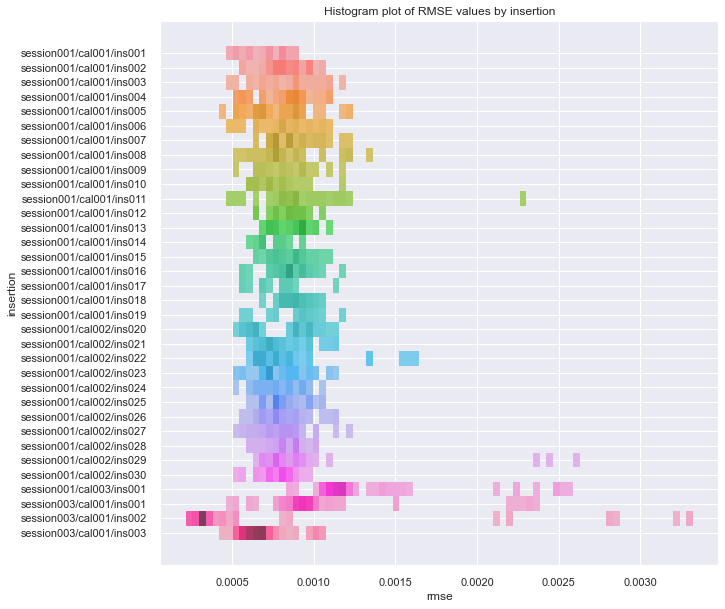

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of RMSE values by insertion" )
sns.histplot(data=both_results, x='rmse', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

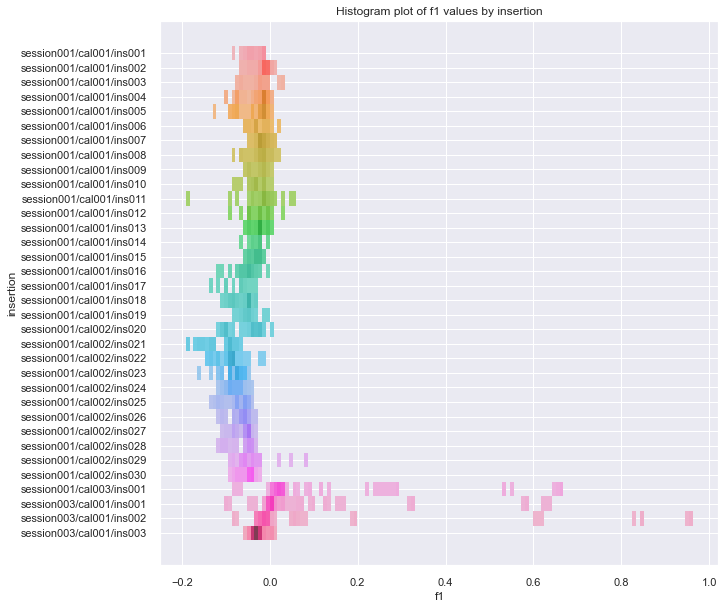

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of f1 values by insertion" )
sns.histplot(data=both_results, x='f1', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

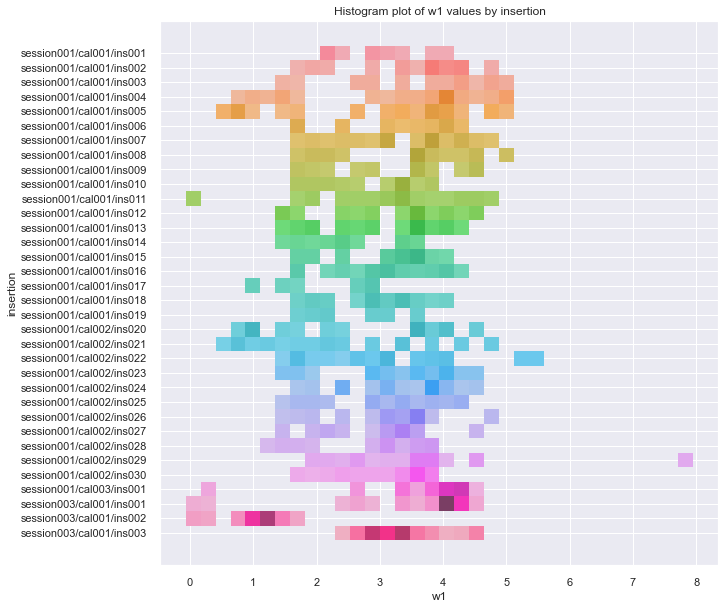

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of w1 values by insertion" )
sns.histplot(data=both_results, x='w1', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

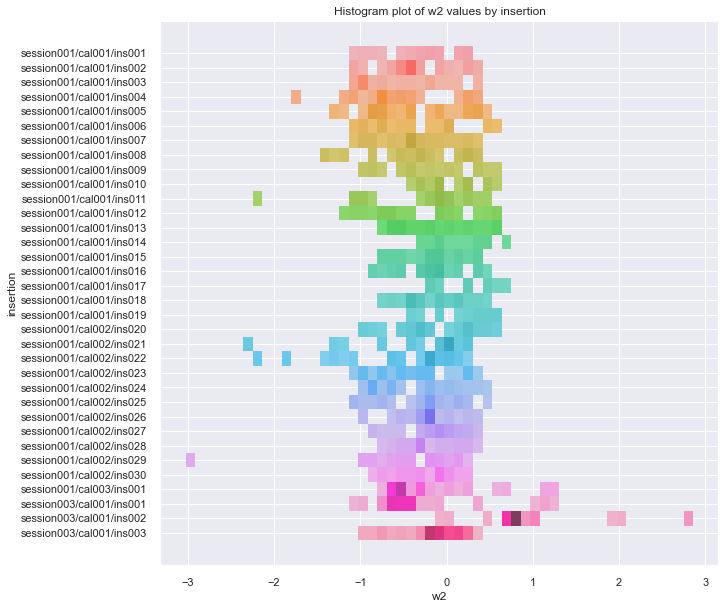

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of w2 values by insertion" )
sns.histplot(data=both_results, x='w2', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()